# Using Histogram of Oriented Gradients (HOG) image match

In [9]:
import numpy as np
import cv2
from skimage import *
from skimage import feature
import math
import matplotlib.pyplot as plt

from scipy.spatial.distance import euclidean
from skimage import io
from skimage import color
from skimage.transform import resize
import math
from skimage.feature import hog

%load_ext autoreload
%autoreload 2
%autosave 180

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Autosaving every 180 seconds


In [10]:
# Load images
ref_im = cv2.imread('/home/daniel-choate/ASAR/s2/TerrainNav/Match_Demos/bolt_cropped.png')
im = cv2.imread('/home/daniel-choate/ASAR/s2/TerrainNav/Match_Demos/bolt_orig.png')


ref_gray = cv2.cvtColor(ref_im, cv2.COLOR_RGB2GRAY)
im_gray = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)

ref_hog, hog_im = feature.hog(ref_gray, pixels_per_cell=(8, 8),
                                        cells_per_block=(2, 2), visualize=True)

print(ref_hog.shape)
print(hog_im.shape)

(42336,)
(400, 200)


LENGTH EXPLANATION

200x400 pixels = 25x50 8x8 blocks
Grouping into 2x2 cells = 24x49 cells
Feature vectors 9 elements

(24 x 49 cells) x (4 blocks per cell) x (9 feature elements per block) = 42336 feature elements 

- Ref_hog displays the 42336 feature elements
- hog_im displays the grayscale gradient information 

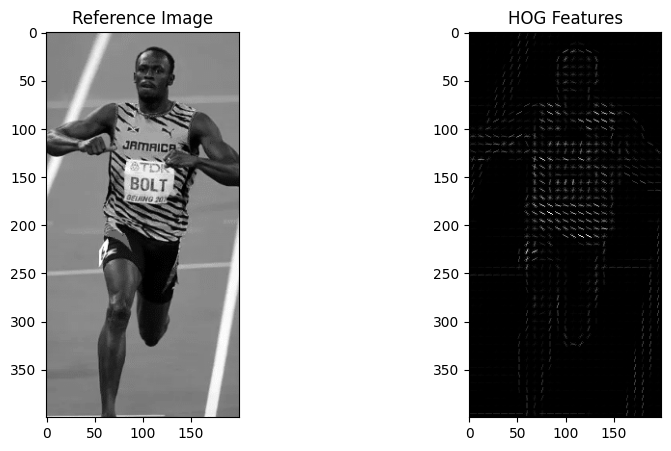

In [11]:
# Visualize the original reference image and the HOG features
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Reference Image")
plt.imshow(ref_gray, cmap='gray')

plt.subplot(1, 2, 2)
plt.title("HOG Features")
plt.imshow(hog_im, cmap='gray')  # Use the visualization of HOG features
plt.show()


In [12]:
# # Redefine the reference imahge (SANITY CHECK)
# ref_CHECK_im = im[50:550, 350:550]
# ref_CHECK, ref_CHECK_hogim = compute_hog(ref_CHECK_im)


# plt.figure(figsize=(10, 5))

# plt.subplot(1, 2, 1)
# plt.title("Reference Image")
# plt.imshow(ref_CHECK_im, cmap='gray')

# plt.subplot(1, 2, 2)
# plt.title("HOG Features")
# plt.imshow(ref_CHECK_hogim, cmap='gray')  # Use the visualization of HOG features
# plt.show()

In [13]:
# SLIDING WINDOW APPROACH 

def sliding_window(image, step_size, window_size):
    """
    Generator to slide a window across the image
    Inputs: image, step size, window size
    Outputs: coordinates(x,y) for the top-left corner of each window
    """
    for y in range(0, image.shape[0] - window_size[1], step_size): # NOTE: image shape reads height x width, idk why
        for x in range(0, image.shape[1] - window_size[0], step_size):
            # print(x,y)
            yield (x, y, image[y:y + window_size[1], x:x + window_size[0]])

def compute_hog(image):
    """Compute HOG features and return the features and visualization."""
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    hog_features, hog_image = feature.hog(gray_image, pixels_per_cell=(8, 8),
                                          cells_per_block=(2, 2), visualize=True)
    return hog_features, hog_image

Sliding window function:
- slides a smaller window of a fixed size over a larger image
- can extract portions that are the same size as the window
- Then, process each window to compute HOG
- Step size: smaller steps can be computationally expensive (how many pixels to move between windows)
- Window_size: defined as (width, height)
- yield used instead of 'return' to keep progress and not store every window

(200, 400)
31.90338744769178 0 0
31.6093277765619 50 0
32.34864842022209 100 0
32.693626291168684 150 0
31.1965066825997 200 0
32.0273098330976 250 0
32.04896407245902 300 0
30.38720657345758 350 0
32.73274876310524 400 0
31.946505536537746 450 0
32.69824770608023 500 0
30.859422357848434 550 0
31.575586167379537 0 50
31.86300873410282 50 50
32.23135043947989 100 50
32.60563440089117 150 50
31.730226648107816 200 50
32.60120447178536 250 50
32.04354369690223 300 50
0.0 350 50
32.45224494696727 400 50
32.11695939390618 450 50
32.82338337926074 500 50
31.043050722978133 550 50
32.35881430796724 0 100
32.20405926044253 50 100
32.72809537889884 100 100
33.17758937386664 150 100
32.6482969002815 200 100
33.147902683500995 250 100
32.53606682391912 300 100
30.583503874955134 350 100
32.969365474356366 400 100
32.5492873487573 450 100
33.34832044917011 500 100
31.727934056295403 550 100
Best match found at location: (350, 50) with distance: 0.0


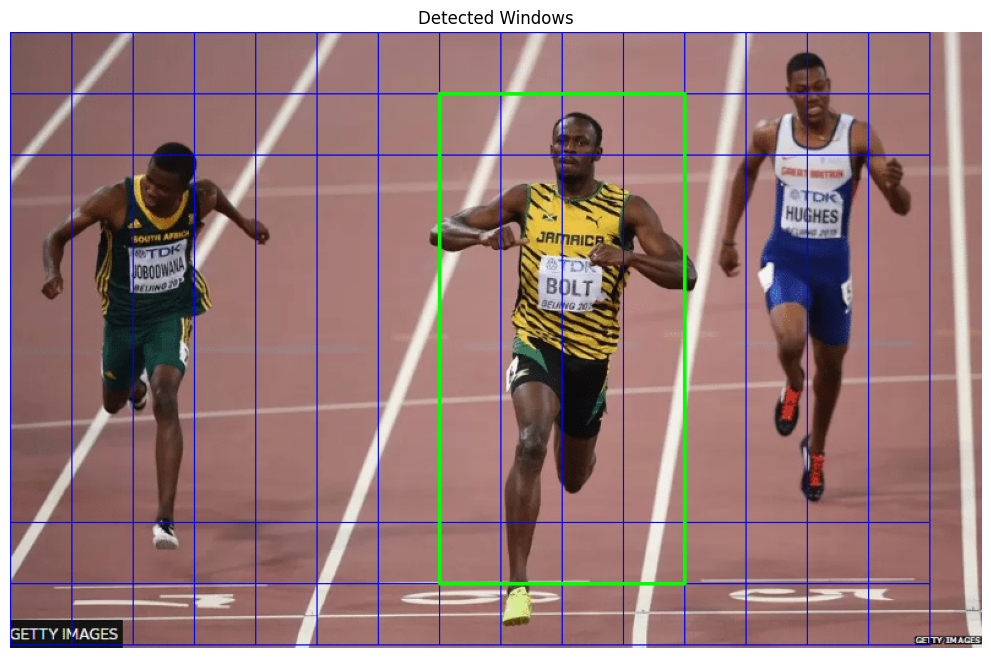

In [16]:
# Get dimensions for sliding window

window_size = ref_im.shape[1], ref_im.shape[0]  # (width, height)
print(window_size)

# Compute HOG features for the reference image
ref_hog, reg_hogim = compute_hog(ref_im)

# Define step size for the sliding window
step_size = 50  # You can adjust this value
best_match = None
best_distance = float('inf')
best_location = (0, 0)
# List to hold matching windows
matching_windows = []

# Create a duplicate image to plot on (DONT USE THE SAME IMAGE FOR A HOG)
im_plot = im.copy()

# Scan the larger image with the sliding window
for (x, y, window) in sliding_window(im, step_size, window_size):
    if window.shape[0] != window_size[1] or window.shape[1] != window_size[0]:
        print("SIZE ISSUE")
        continue  
    # Compute HOG features for the current window
    window_hog, window_hogim = compute_hog(window)
    
    # # Visualize the original reference image and the HOG features
    # plt.figure(figsize=(10, 5))
    # plt.title("Reference Image")
    # plt.imshow(window_hogim, cmap='gray')
    # plt.show()
    #  # Visualize the original reference image and the HOG features
    # plt.figure(figsize=(10, 5))
    # plt.title("Reference Image")
    # plt.imshow(reg_hogim, cmap='gray')
    # plt.show()
    
    distance = euclidean(ref_hog, window_hog)
    print(distance, x,y)

    # Update the best match if the current window is more similar
    if distance < best_distance:
        best_distance = distance
        best_match = window
        best_location = (x, y)

    # OPTIONALLY, Draw a rectangle for the current window (red)
    cv2.rectangle(im_plot, 
                  (x, y), 
                  (x + window_size[0], y + window_size[1]), 
                  (255, 0, 0), 1)  # Red rectangle with thickness 1 for all windows
    # It will come out blue because of the BGR to RGB conversion 
    
    
    # # Compare HOG features DIFFERENT VERSION ????
    # similarity = np.dot(ref_hog, window_hog) / (np.linalg.norm(ref_hog) * np.linalg.norm(window_hog))
    
    # # Define a threshold for similarity
    # threshold = 0.5  # Adjust based on your requirements
    # if similarity > threshold:
    #     matching_windows.append((x, y, window))

print(f"Best match found at location: {best_location} with distance: {best_distance}")

# Visualize best location 
cv2.rectangle(im_plot, (best_location[0], best_location[1]), 
              (best_location[0] + window_size[0], best_location[1] + window_size[1]), 
              (0, 255, 0), 2)

# Show the resulting image with detected windows
plt.figure(figsize=(15, 8))
plt.imshow(cv2.cvtColor(im_plot, cv2.COLOR_RGB2BGR))
plt.title('Detected Windows')
plt.axis('off')
plt.show()


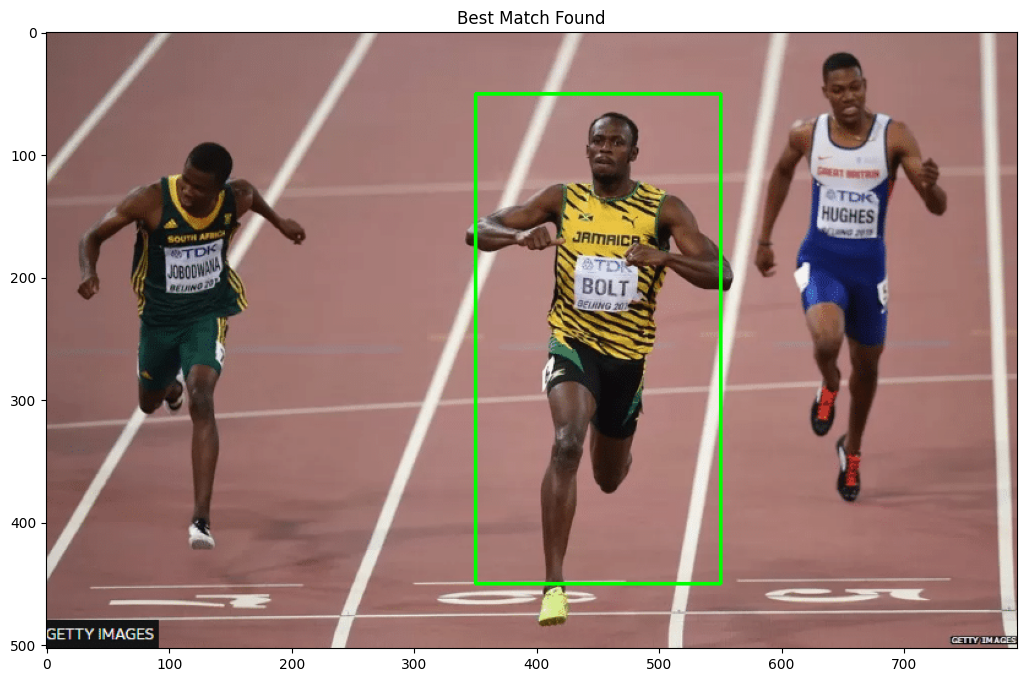

In [17]:
# Visualize the best match
# First, reset the image
im = cv2.imread('/home/daniel-choate/ASAR/s2/TerrainNav/Match_Demos/bolt_orig.png') 
plt.figure(figsize=(15, 8))
cv2.rectangle(im, (best_location[0], best_location[1]), 
              (best_location[0] + window_size[0], best_location[1] + window_size[1]), 
              (0, 255, 0), 2)

plt.imshow(cv2.cvtColor(im, cv2.COLOR_RGB2BGR))
plt.title("Best Match Found")
plt.show()

Euclidean distance: calculates straight-line distance between two points in a multidimensional dpace 

Cosine Similarity: measures cosine of angle between two vectors in a multidimensional space, indicating how similar directions are
- 1: vectors aligned perfect
- 0: vectors orthogonal, no similarity 
- -1: opposite 